In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from mxnet.gluon import data as gdata
from mxnet import ndarray as nd
from mxnet import autograd, nd, gluon, init, context
import math
import sys
import time

### Download the dataset and show example

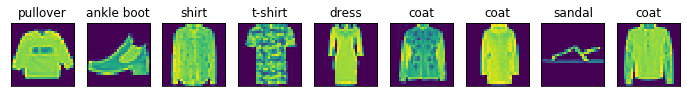

In [2]:
mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test  = gdata.vision.FashionMNIST(train=False)

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    fig, axs = plt.subplots(1, len(images),figsize=(12,12))
    for f, img, lbl in zip(axs, images, labels):
        f.imshow(img.reshape((28,28)).asnumpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        
X, y = mnist_train[0:9]
show_fashion_mnist(X, get_fashion_mnist_labels(y))

### Load data in batches

In [3]:
batch_size = 256
transformer = gdata.vision.transforms.ToTensor()
if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 4
    
train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                             batch_size, shuffle=True,
                             num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
                            batch_size, shuffle=False,
                            num_workers=num_workers)

# LeNet5

In a rough sense, we can think LeNet as consisting of two parts:
(i) a block of convolutional layers; and
(ii) a block of fully-connected layers.
The following figure shows the model:

![Data flow in LeNet 5. The input is a handwritten digit, the output a probabilitiy over 10 possible outcomes.](img/lenet.svg)

http://yann.lecun.com/exdb/lenet/

### Define the model

In [4]:
from mxnet.gluon import nn

net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        # Dense will transform the input of the shape (batch size, channel,
        # height, width) into the input of the shape (batch size,
        # channel * height * width) automatically by default
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10))

### Print model structure

In [5]:
X = nd.random.uniform(shape=(1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (1, 6, 28, 28)
pool0 output shape:	 (1, 6, 14, 14)
conv1 output shape:	 (1, 16, 10, 10)
pool1 output shape:	 (1, 16, 5, 5)
dense0 output shape:	 (1, 120)
dense1 output shape:	 (1, 84)
dense2 output shape:	 (1, 10)


### Define classification accuracy

In [6]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).sum().asscalar()

In [7]:
def evaluate_accuracy(net, data_iter, ctx=None):
    if not ctx:  # Query the first device the first parameter is on.
        ctx = list(net.collect_params().values())[0].list_ctx()[0]
    metric = [0.0, 0]  # num_corrected_examples, num_examples
    for X, y in data_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        metric[0] = metric[0] + accuracy(net(X), y)
        metric[1] = metric[1] + y.size
    return metric[0]/metric[1]

In [8]:
# Helper
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    return context.gpu(i) if context.num_gpus() >= i + 1 else context.cpu()

### Training loop

In [9]:
def train(net, train_iter, test_iter, num_epochs, lr, ctx=try_gpu()):
    net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(),
                            'sgd', {'learning_rate': lr})
    for epoch in range(num_epochs):
        metric = [0.0,0.0,0]  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            # Update metrics
            metric[0] = metric[0] + l.sum().asscalar()
            metric[1] = metric[1] + accuracy(y_hat, y)
            metric[2] = metric[2] + X.shape[0]
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
        test_acc = evaluate_accuracy(net, test_iter)
    print('loss %.3f, train acc %.3f, test acc %.3f' % (train_loss, train_acc, test_acc))

In [10]:
lr, num_epochs = 0.9, 10
train(net, train_iter, test_iter, num_epochs, lr)

loss 0.473, train acc 0.822, test acc 0.825
